# Image classification with convolutional neural networks

In this script we create, train, and evaluate an image classifier based on convolutional neural networks (CNNs).

In [54]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import copy

In [55]:
# Initialization function for the network's parameters
def init_params(m, seed=0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02, generator=torch.manual_seed(seed))
        m.bias.data.fill_(0.01)
    return

## Dataset

In this lab we work with the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset: it's similar to MNIST, but these are images of clothes from Zalando instead of digits.

<center><a href="https://medium.com/ml2vec/intro-to-pytorch-with-image-classification-on-a-fashion-clothes-dataset-e589682df0c5">
    <img src="https://miro.medium.com/max/1400/1*jXssb_WjoYZgepOCfdQfJA.png" width="400"></a></center>

Like MNIST, each image comes with a label between 0 and 9 (10 classes). The mapping between integer labels and actual classes (0 = t-shirt, 1 = trousers, etc.) can be found [here](https://github.com/zalandoresearch/fashion-mnist#labels).

In [56]:
# Dataset repository - remember to change it according to your folder structure
data_dir = '../datasets/'

# Just like MNIST, you can download the data by setting 'download=True' directly from pytorch
train_data = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=torchvision.transforms.ToTensor())

num_classes = len(train_data.classes)
print(num_classes)

print(len(train_data))
# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(500))
test_data = Subset(train_data, torch.arange(50))

# We define the train and validation sets and dataloaders as in the previous script
n_train_examples = int(len(train_data)*0.8)
print(n_train_examples)
n_valid_examples = len(train_data) - n_train_examples
print(n_valid_examples)
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples], generator=torch.manual_seed(0))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(0))
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

10
60000
400
100


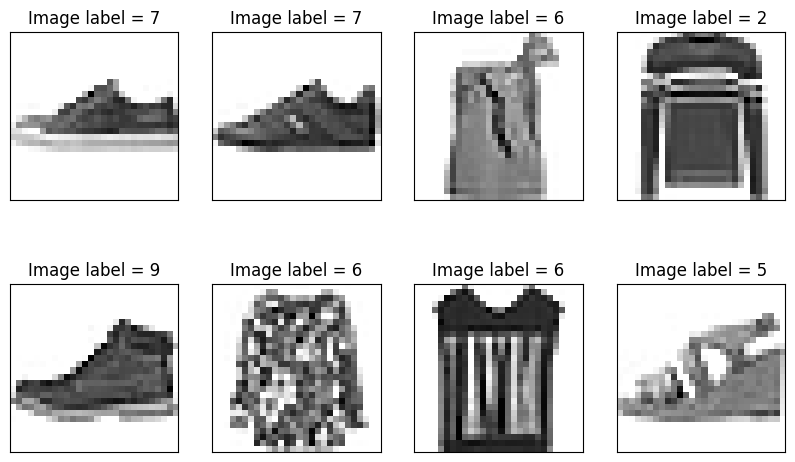

In [57]:
# Get a batch of images from the train dataloader and print it
image_batch_example, labels_batch_example = next(iter(train_dataloader))

plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze().detach(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## CNN classifier

A CNN classifier usually consists of:
- one or several convolutional layers/modules that produce intermediate latent representations called ***feature maps***
- an output linear layer performing classification from the feature maps

<center><a href="https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac">
    <img src="https://miro.medium.com/max/700/1*LTRcAyl6zuuJvpU-5KECZA.png"></a></center>

### Example

In [58]:
# Let us create a first CNN layer, with:
# - a convolution function, with 16 output channels, kernel_size=5, padding=2, and bias
# - a non-linear activation function (ReLU)
# - a max pooling function

cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)
print(out1.shape)

torch.Size([8, 16, 14, 14])


In [59]:
# TO DO: create the second CNN layer, with the same structure as the first one
# (same non-linear activation and max pooling functions), but the convolution function
# now has 16 input channels and 32 output channels
# After creating it, apply it to 'out1' to compute out2, and print the shape of out2.
cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out2 = cnn_layer2(out1)
print(out2.shape)


torch.Size([8, 32, 7, 7])


In [60]:
# Now, we define a linear layer to perform classification (as in Lab 3)

# First, we need to flatten out2, since linear layers in pytorch process vectors (or more precisely batches of vectors)
# The resulting vector should have a shape = (batch_size, 32 x 7 x 7)
out_vec = out2.reshape(out2.shape[0], -1)
print(out_vec.shape)

# TO DO: define a Linear layer with appropriate parameters
# - the input size is given by checking the shape of 'out_vec'
# - the output size is the number of classes in the dataset
# Once defined, apply this layer to out_vec


torch.Size([8, 1568])


### General module

Now, let's create a general CNN classification network, train and test it. The CNN module takes as inputs the number of output channels in each layer (and the number of classes), but we also have to explicitly provide the input size of the Linear layer, since it depends on many other parameters (image size, but also kernel, padding, stride, number of channels in the convolutions...). Instead of computing it with a general (and heavy) formula, it's easier to just get it from an example (as above), and then pass it as an input parameter.

**Note**: there are ways to alleviate this issue (e.g., using another convolution layer with as many kernels as output classes, and then global pooling)... but that's outside the scope of these labs.

In [61]:
# TO DO: Define the CNN classifier module ('__init__' and 'forward' methods).
# It's architecture (=layers) is the same as in the example above.

class CNNClassif(nn.Module):
    def __init__(self, linear_input_size, num_channels1, num_channels2, num_classes):
        super(CNNClassif, self).__init__()
        self.cnn_layers = nn.Sequential(nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2),
                                        nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2))
        self.linear = nn.Linear(linear_input_size, num_classes)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        return x


In [62]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 10
input_size_linear = 32*7*7
model = CNNClassif(input_size_linear, num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization of the network's parameters
model.apply(init_params)

Total number of parameters:  28938


CNNClassif(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=1568, out_features=10, bias=True)
)

## Training and evaluation

The evaluation and training function (with validation) are almost the same as in lab4.1, except we don't need to vectorize the images. Indeed, MLPs process (batches of) vectors, while CNNs directly process (batches of) images.

<span style="color:red">**Exercice 3**</span> Write the evaluation and training function with validation. Train the model using the training parameters below, and plot the training loss and validation accuracy over epochs. Compute the test accuracy.

In [63]:
# Evaluation function
def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            # images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [64]:
def training_cnn_classifier(model, train_dataloader, validation_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)

    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)

    # Initialize a list for storing the training loss over epochs
    train_losses = []

    best_model = None
    best_valid_accuracy = 0.0
    valid_accuracies = []


    # Training loop
    for epoch in range(num_epochs):

        # Initialize the training loss for the current epoch
        tr_loss = 0

        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):

            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorize the images
            # vectorized_batch = images.view(images.size(0), -1)
            # - calculate the predicted labels from the vectorized images using 'model_tr'
            y_pred = model_tr(images)
            # - using loss_fn, calculate the 'loss' between the predicted and true labels
            loss = loss_fn(y_pred, labels)
            # - set the optimizer gradients at 0 for safety
            optimizer.zero_grad()
            # - compute the gradients (use the 'backward' method on 'loss')
            loss.backward()
            # - apply the gradient descent algorithm (perform a step of the optimizer)
            optimizer.step()

            # For each batch, we update the current epoch loss
            tr_loss += loss.item()

        # At the end of each epoch, get the average training loss over all batches
        tr_loss = tr_loss / len(train_dataloader)
        train_losses.append(tr_loss)

        # Evaluate the model on the validation set
        valid_accuracy = eval_mlp_classifier(model_tr, validation_dataloader)
        valid_accuracies.append(valid_accuracy)

        # Check if the current validation accuracy is the best we've seen so far
        if valid_accuracy > best_valid_accuracy:
          best_valid_accuracy = valid_accuracy
          best_model = copy.deepcopy(model_tr)
        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}, Validation accuracy: {:.2f}%'.format(epoch+1, num_epochs, tr_loss, valid_accuracy))

    return best_model, train_losses, valid_accuracies


In [65]:
# Training parameters
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

best_model, train_loss_values_without_bacth_norm, valid_loss_values_without_bacth_norm = training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/40], Training loss: 1.7410, Validation accuracy: 44.00%
Epoch [2/40], Training loss: 0.9096, Validation accuracy: 70.00%
Epoch [3/40], Training loss: 0.6802, Validation accuracy: 65.00%
Epoch [4/40], Training loss: 0.6097, Validation accuracy: 77.00%
Epoch [5/40], Training loss: 0.5153, Validation accuracy: 72.00%
Epoch [6/40], Training loss: 0.4431, Validation accuracy: 75.00%
Epoch [7/40], Training loss: 0.4173, Validation accuracy: 74.00%
Epoch [8/40], Training loss: 0.3379, Validation accuracy: 73.00%
Epoch [9/40], Training loss: 0.2992, Validation accuracy: 66.00%
Epoch [10/40], Training loss: 0.2599, Validation accuracy: 73.00%
Epoch [11/40], Training loss: 0.2446, Validation accuracy: 79.00%
Epoch [12/40], Training loss: 0.1957, Validation accuracy: 80.00%
Epoch [13/40], Training loss: 0.1864, Validation accuracy: 65.00%
Epoch [14/40], Training loss: 0.1651, Validation accuracy: 77.00%
Epoch [15/40], Training loss: 0.1532, Validation accuracy: 76.00%
Epoch [16/40], Trai

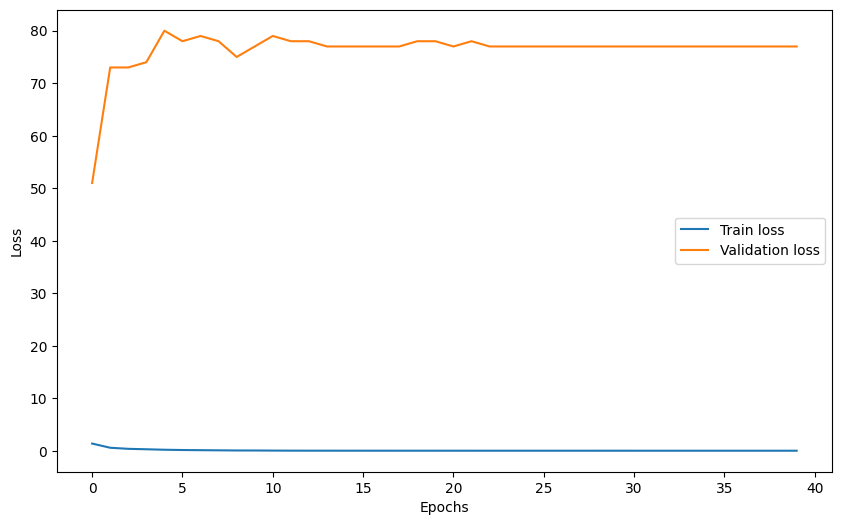

In [66]:
# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Train loss')
plt.plot(valid_loss_values, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Batch normalization

When passing images to a CNN, each image might have different distribution / statistics. This causes the gradient at each batch to change a lot, and this makes the stochastic gradient descent algorithm quite unstable.

To prevent from this problem, we use **batch normalization**, which basically normalizes each batch of data to a given mean / standard deviation. This makes training more stable, and usually significantly faster.

Batch norm is easy to write in Pytorch (see the [doc](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d)).

**Note**: batch normalization should be only used for training, but should be disabled when testing the model. That's why we set `model.eval()` in the evaluation function.

In [67]:
# TO DO : rewrite the CNNClassif module, but insert BatchNorm2D in each CNN layer, between RELU and Maxpooling.
class CNNClassif(nn.Module):
    def __init__(self, linear_input_size, num_channels1, num_channels2, num_classes):
        super(CNNClassif, self).__init__()
        self.cnn_layers = nn.Sequential(nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels1),
                                        nn.MaxPool2d(kernel_size=2),
                                        nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                                        nn.ReLU(),
                                        nn.BatchNorm2d(num_channels2),
                                        nn.MaxPool2d(kernel_size=2))
        self.linear = nn.Linear(linear_input_size, num_classes)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.linear(x)
        return x

In [68]:
# TO DO:
# - instantiate the model and initialize its parameters
num_channels1 = 16
num_channels1 = 16
num_channels2 = 32
num_classes = 10
input_size_linear = 32*7*7
model = CNNClassif(input_size_linear, num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization of the network's parameters
model.apply(init_params)

Total number of parameters:  29034


CNNClassif(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Linear(in_features=1568, out_features=10, bias=True)
)

In [69]:
# - train it, and plot the training and validation losses
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

best_model, train_loss_values_with_bacth_norm, valid_loss_values_with_bacth_norm = training_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate)

Epoch [1/40], Training loss: 1.3664, Validation accuracy: 51.00%
Epoch [2/40], Training loss: 0.5669, Validation accuracy: 73.00%
Epoch [3/40], Training loss: 0.3600, Validation accuracy: 73.00%
Epoch [4/40], Training loss: 0.2787, Validation accuracy: 74.00%
Epoch [5/40], Training loss: 0.1878, Validation accuracy: 80.00%
Epoch [6/40], Training loss: 0.1348, Validation accuracy: 78.00%
Epoch [7/40], Training loss: 0.1039, Validation accuracy: 79.00%
Epoch [8/40], Training loss: 0.0764, Validation accuracy: 78.00%
Epoch [9/40], Training loss: 0.0476, Validation accuracy: 75.00%
Epoch [10/40], Training loss: 0.0440, Validation accuracy: 77.00%
Epoch [11/40], Training loss: 0.0263, Validation accuracy: 79.00%
Epoch [12/40], Training loss: 0.0144, Validation accuracy: 78.00%
Epoch [13/40], Training loss: 0.0097, Validation accuracy: 78.00%
Epoch [14/40], Training loss: 0.0078, Validation accuracy: 77.00%
Epoch [15/40], Training loss: 0.0062, Validation accuracy: 77.00%
Epoch [16/40], Trai

In [70]:
# - compute and print the test accuracy
test_accuracy = eval_mlp_classifier(best_model, test_dataloader)
print('Test accuracy: {:.2f}%'.format(test_accuracy))

Test accuracy: 94.00%


<span style="color:red">**Exercice 4**</span> On a single plot, display the training loss with and without batch norm. On another plot, display the validation accuracy with and without batch norm. What do you conclude?

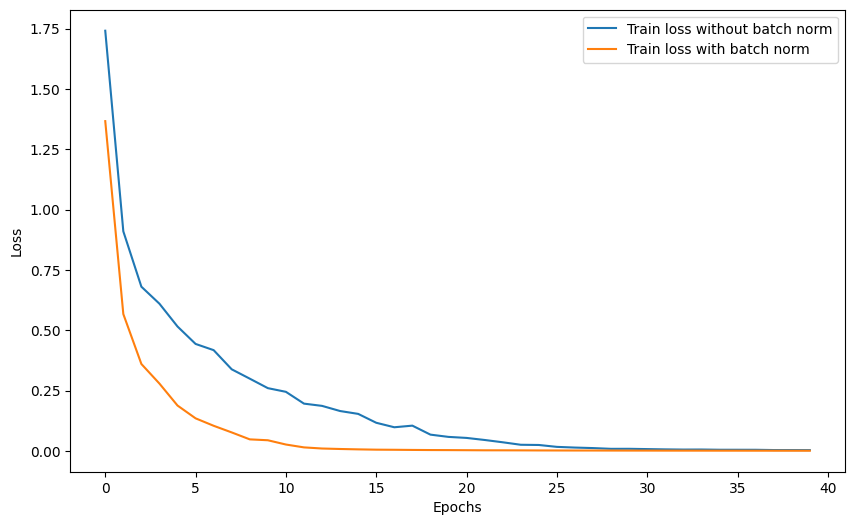

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_values_without_bacth_norm, label='Train loss without batch norm')
plt.plot(train_loss_values_with_bacth_norm, label='Train loss with batch norm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


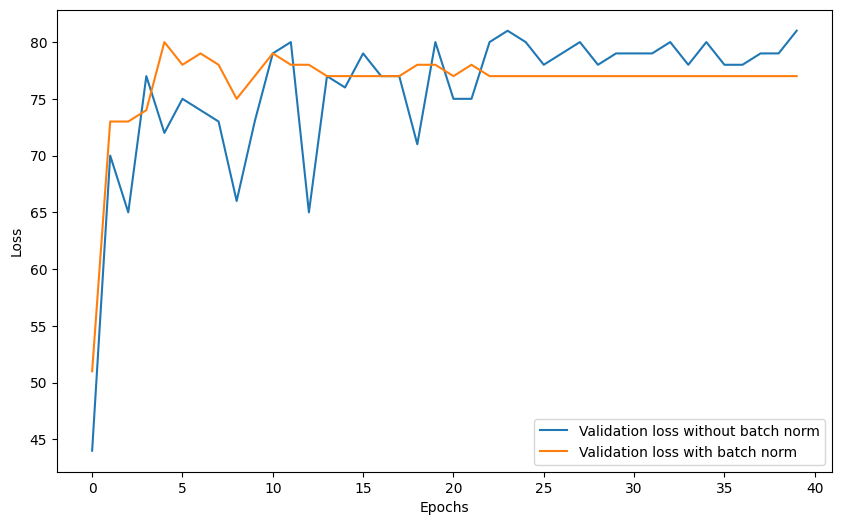

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(valid_loss_values_without_bacth_norm, label='Validation loss without batch norm')
plt.plot(valid_loss_values_with_bacth_norm, label='Validation loss with batch norm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
# Comment: The model with batch normalization converges faster
# and to a lower loss value than the model without batch normalization.